<a href="https://colab.research.google.com/github/Yustira/ANN-MT-1D/blob/main/Data_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install SimPEG==0.11.6
!pip install git+https://github.com/simpeg/tle-magnetotelluric_inversion
!pip install pymatsolver==0.1.3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
from SimPEG import (Mesh, Maps, SolverLU, DataMisfit, Regularization,
                    Optimization, InvProblem, Inversion, Directives, Utils)
from tleMT.MT1D import MT1DProblem, MT1DSurvey, MT1DSrc, ZxyRx, Survey, AppResPhaRx
try: 
    from pymatsolver import PardisoSolver as Solver
except importError:
    from SimPEG import SolverLU as SolverLU
%matplotlib inline

In [ ]:
def build_mesh(frequency, max_depth_core, ncell_per_skind = 1e2, n_skind = 2, max_hz_core = 5e1):
    rxloc = np.r_[0]
    rx = ZxyRx(rxloc, component='both', frequency=frequency)
    src = MT1DSrc([rx])
    survey = MT1DSurvey([src])
    max_depth_core = max_depth_core
    mesh = survey.setMesh(sigma = 1e-2, max_depth_core = max_depth_core, ncell_per_skind = ncell_per_skind, 
                          n_skind = n_skind, core_meshType = 'log', max_hz_core = max_hz_core)
    return mesh, survey

In [ ]:
def plot_mesh(mesh):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    mesh.plotGrid(centers=True, faces=True, ax=ax)
    ax.legend(['centers', 'faces'])
    ax.invert_xaxis()
    ax.set_xlabel('Z (m)')
    ax.grid(which='both', lw=0.5)

In [ ]:
def model_ref(mesh, survey, layers_tops, rho_layers, loglog=True):
    prob = MT1DProblem(mesh, sigmaMap = Maps.ExpMap(mesh), verbose = True, Solver = Solver)
    prob.pair(survey)
    rho = np.ones(mesh.nC)*np.nan

    for layers_top, rho_layer in zip(layers_tops, rho_layers):
        inds = mesh.vectorCCx < layers_top
        rho[inds] = rho_layer

    sigma = 1/rho
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    rho_plt = np.repeat(rho, 2, axis=0)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    if loglog == True:
        ax.loglog(-z, rho_plt, lw=2)
    else:
        ax.semilogy(-z, rho_plt, lw=2)

    ax.set_ylabel("$\\rho$ $(\\Omega m)$", fontsize=14)
    ax.set_xlabel("z (m)", fontsize=14)
    ax.grid(True, which='both', linewidth=0.4)
    ax.set_xlim(-z.max(), max_depth_core)
    ax.set_ylim(5e0, 2e3)

    return z, sigma, rho

In [ ]:
def survey_dobs(survey, sigma, std):
    mtrue = np.log(sigma) 
    dtrue = survey.dpred(mtrue) 
    np.random.seed(1)
    uncert = std*np.abs(dtrue)
    noise = uncert*np.random.randn(survey.nFreq*2)
    survey.dobs = dtrue+noise
    return survey.dobs, dtrue

def omega(frequency):
    return 2*np.pi*frequency

def appres_phase_from_data(survey, data, frequency):
    Zxy_real = data.reshape((survey.nFreq, 2))[:, 0]
    Zxy_imag = data.reshape((survey.nFreq, 2))[:, 1]
    Zxy = Zxy_real + 1j*Zxy_imag
    app_res = abs(Zxy)**2/(mu_0*omega(frequency))
    phase = np.rad2deg(np.arctan(Zxy_imag/Zxy_real))
    return app_res, phase

In [ ]:
def fitting(periods, app_res_true, app_res_obs, phase_true, phase_obs, tp1, tp2, title):
    fig, ax = plt.subplots(2, 1, figsize=(9, 4*2))
    ax[0].loglog(periods, app_res_obs, tp1, lw=1.5, label='$d_{noise}$')
    ax[0].loglog(periods, app_res_true, tp2, color='orange', lw=2.5, label='$d_{true}$')
    ax[0].set_title(title, fontsize=14)
    ax[0].set_ylabel('$\\rho_a$ $(\\Omega m)$', fontsize=14)
    ax[0].set_ylim(5e0, 2e3)

    ax[1].semilogx(periods, phase_obs, tp1, lw=1.5, label='$d_{noise}$')
    ax[1].semilogx(periods, phase_true, tp2, color='orange', lw=2.5, label='$d_{true}$')
    ax[1].set_ylabel('$\\phi$ $(^\circ)$', fontsize=14)
    ax[1].set_ylim([0, 90])

    for a in ax:
        a.set_xlabel('T (s)', fontsize=14)
        a.legend(fontsize=10)
        a.grid(True, which='both', lw=0.5)
        a.set_xlim([periods.min(), periods.max()])

    plt.tight_layout()
    plt.show() 
    return fig

In [ ]:
def save_data(name, periods, app_res, phase):    
    d_obs = np.array([periods, app_res, phase])
    np.savetxt(str(name+".csv"), d_obs.transpose(), delimiter=',', fmt='%f', header='periods, rho, phi')

>> Smallest cell size = 1 m
>> Padding distance = 316227 m
>> # of padding cells 28
>> # of core cells cells 285


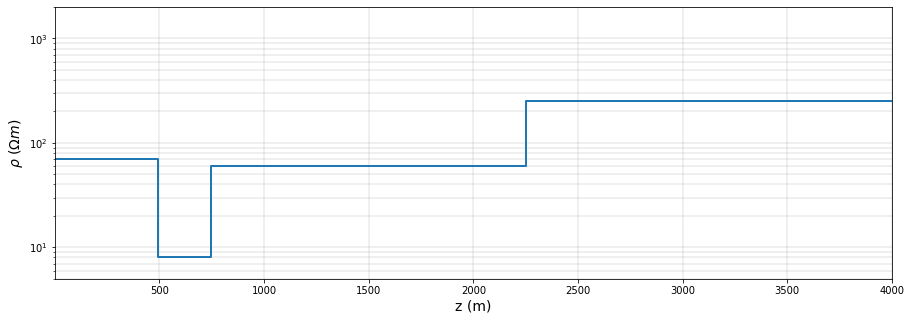

In [ ]:
layers_tops = np.r_[0, -500, -750, -2250]
rho_layers = np.r_[70, 8, 60, 250]
frequency = np.logspace(-3, 3, 200)
periods = 1/frequency
max_depth_core = 4000
mesh, survey = build_mesh(frequency, max_depth_core)
#plot_mesh(mesh)
z, sigma, rho = model_ref(mesh, survey, layers_tops, rho_layers, False)

>> Compute fields
Delete Matrices
Factorize A matrix


/usr/local/lib/python3.7/dist-packages/discretize/operators/differential_operators.py:2334: UserWarning: cell_gradient_BC is deprecated and is not longer used. See cell_gradient
  warnings.warn("cell_gradient_BC is deprecated and is not longer used. See cell_gradient")


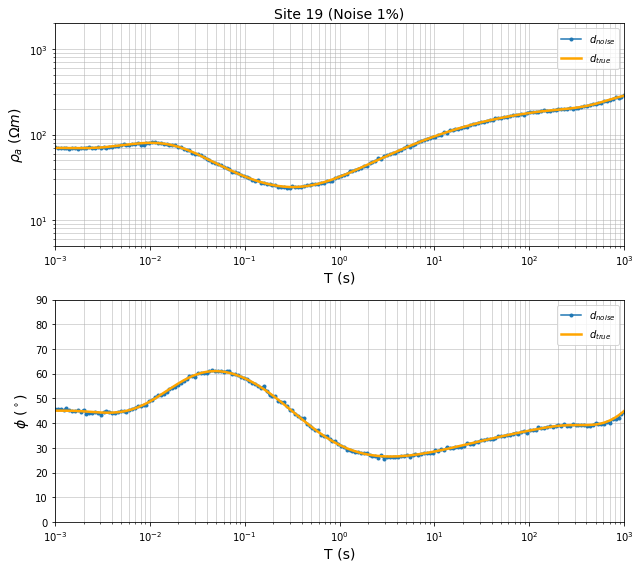

In [ ]:
std = 0.01
d_obs, d_true = survey_dobs(survey, sigma, std)
app_res_true, phase_true = appres_phase_from_data(survey, d_true, frequency)
app_res_obs, phase_obs = appres_phase_from_data(survey, d_obs, frequency)
fig = fitting(periods, app_res_true, app_res_obs, phase_true, phase_obs, '.-', '-', "Site 19 (Noise 1%)")

In [ ]:
fig.savefig('data2.png')
save_data('data_2', periods, app_res_obs, phase_obs)